<center>
    <h1>Logistic Regression</h1>
</center>

---

<p align = ”justify”>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In statistics, the <b>logistic model</b> (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1 and the sum adding to one.<a href="https://en.wikipedia.org/wiki/Logistic_regression"><sup>[WiKiPeDia - Logistic Regression]</sup></a></p>

<p align = ”justify”>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Logistic Regression is an extension of <b>Linear Regression</b> where, the constants are raised to the power of <i>exponential</i>. The Linear Regression is given as $y = \alpha_{1}x_{1} + \alpha_{2}x_{2} + ... + \alpha_{n}x_{n} + C_{0}$ where $(\alpha_{1}, \alpha_{2} ... \alpha_{n}, C_{0})$ are the coefficients. Thus, extending the formula, we can define $y$ for Logistic Regression as:</p>

$$
y = \frac{1}{1 + e^{-(\alpha_{1}x_{1} + \alpha_{2}x_{2} + ... + \alpha_{n}x_{n} + C_{0})}} \in [0, 1]
$$

Now, for any Binary-Classification, we choose a Threshold ($\sigma$) which defines the class of the value as:

$$
y = \begin{cases}
    1,  & \text{if } x \geq \sigma \\
    0,  & \text{otherwise}
\end{cases}
$$

**Table of Contents**
    1. Data Analysis and Preparation for Model-Fitting
    2. Model Fitting, and Evaluation
    3. PySpark Implementation
    
**DISCLAIMER** This Data might not give a good result with Logistic Regression, but sake of Learning Purpose, we train the model, and try to improve the accuracy.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('basicPresentationStyle'); # NOTE : This is a Custom MatPlotLib style-Sheet

In [2]:
!wget https://github.com/IBM/coursera/raw/master/coursera_ml/a2.parquet

--2020-06-04 18:04:59--  https://github.com/IBM/coursera/raw/master/coursera_ml/a2.parquet
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ml/a2.parquet [following]
--2020-06-04 18:05:00--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ml/a2.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ml/a2.parquet [following]
--2020-06-04 18:05:00--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ml/a2.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [2]:
data = pd.read_parquet('a2.parquet')

**About the Data:** The Data Contains Sensor-ID and three Locations *(x, y, z)* on which two Distinct Class *(0, 1)* are Defined. In this Problem, we try to fit a Logistic Regression Model to **Predict** the Class based on *(x, y, z)* Values.

## Data Analysis and Preparation for Model-Fitting

In [3]:
data.describe()

,CLASS,SENSORID,X,Y,Z
count,3042.000000,3.042000e+03,3042.000000,3042.000000,3042.000000
mean,0.465483,2.146354e+10,0.000690,-0.013964,-0.057929
std,0.498889,1.547886e+10,77.773002,56.185020,132.535466
min,0.000000,0.000000e+00,-312.421577,-1075.710000,-558.286626
25%,0.000000,8.589935e+09,-12.966021,-7.680157,-17.619047
50%,0.000000,1.717987e+10,-0.145056,-0.270530,-0.294045
75%,1.000000,3.435974e+10,12.611825,6.422914,21.830274
max,1.000000,5.153961e+10,380.664340,234.785009,453.569235


<p align = ”justify”>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>CLASS</b> has a mean of $\approx 0.465$ which signifies that more than 50% of the Data falls into Category-0. This can be validated from $IQ_{50\text{%}} = 0$, while $IQ_{75\text{%}} = 1$. We can even do a value count, which gives the result as:</p>

```python
dict(data.CLASS.value_counts())
>> {0: 1626, 1: 1416}
```

<p align = ”justify”>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The co-ordinate value <i>(x, y, z)</i> are highly distributed, with a high Standard Deviation ($\sigma^{2}$). The Scale of the Data is also not on the same range, thus we can either do a <i>MinMaxScaling</i><a href="https://spark.apache.org/docs/latest/ml-features#standardscaler"><sup>[PySpark - Standard Scaler]</sup></a> to Scale the Value $\in [0, 1]$, or we can <i>Normalize</i><a href="https://spark.apache.org/docs/latest/ml-features#normalizer"><sup>[PySpark - Normalizer]</sup></a> (also called <i>p-norm</i> or <i>$l_{p}$-norm</i>) the value, considering $p = 1$, which is equivalent to <i>Manhattan Distance</i>. Below are the formula for Scaling the Data ($x_{scaled}$) and Normalizing ($x_{p-norm}$).</p>

$$
x_{scaled}^{i} = \frac{x^{i} - X_{min}}{X_{max} - X_{min}}
$$

$$
||x_{p-norm}^{i}|| := (\sum_{i = 1}^{n}|x_{i}|^p)^{1/p}
$$

In [4]:
xScalar, yScalar, zScalar = [MinMaxScaler(feature_range = (-1, 1)) for i in range(3)]

In [5]:
for sclrObj, labelName, curLabels in zip([xScalar, yScalar, zScalar], ['xScaled', 'yScaled', 'zScaled'], 'X Y Z'.split()):
    data[labelName] = sclrObj.fit_transform(data[curLabels].values.reshape(-1, 1)).reshape(1, -1)[0]

In [6]:
data.sample(5)

,CLASS,SENSORID,X,Y,Z,xScaled,yScaled,zScaled
2717,0,25769803826,67.136746,-21.256033,107.332097,0.095271,0.609245,0.315639
2366,1,42949672994,-1.368215,0.636289,-2.454935,-0.102410,0.642656,0.098638
527,0,34359738496,-190.639475,135.167676,276.756798,-0.648580,0.847970,0.650519
1567,0,25769803838,-10.003068,65.851312,-216.739402,-0.127328,0.742183,-0.324909
2823,0,25769803854,178.623988,-47.075277,84.383067,0.416983,0.569841,0.270279


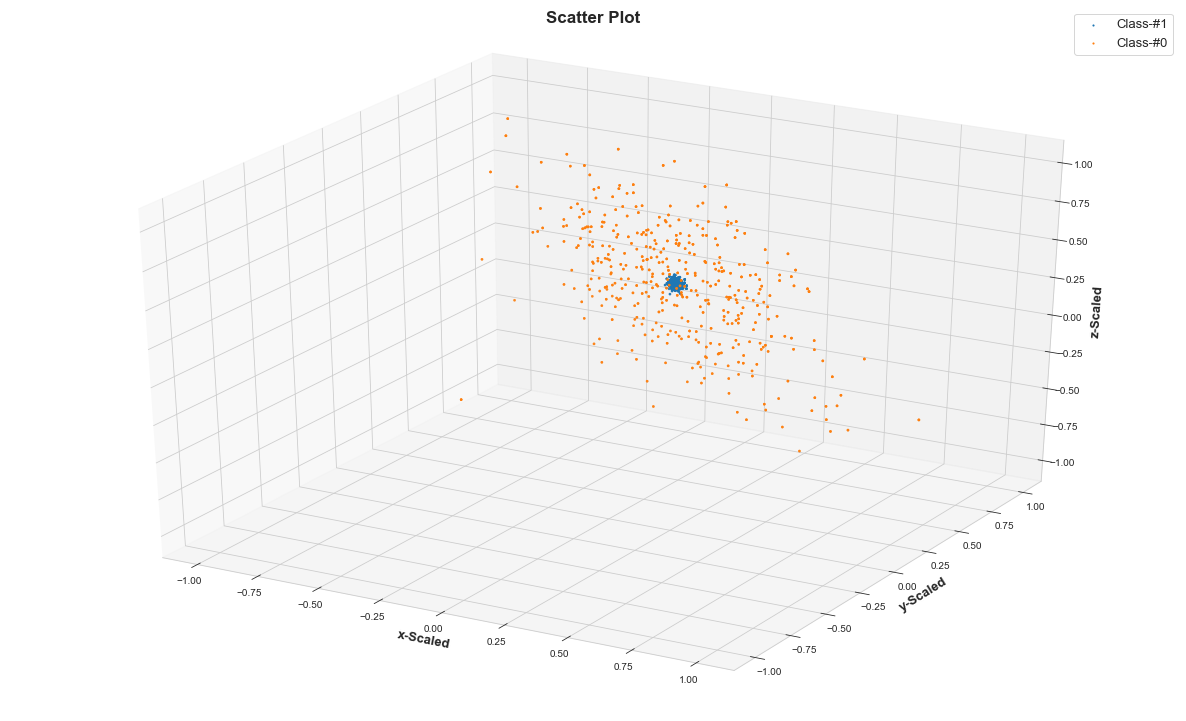

In [7]:
fig = plt.figure(figsize = (21, 13))
axs = fig.add_subplot(111, projection = '3d')

classTrue = data[data.CLASS == 1]
classFalse = data[data.CLASS == 0]

for clsName, _data in zip(['Class-#1', 'Class-#0'], [classTrue, classFalse]):
    x, y, z = _data.xScaled.values, _data.yScaled.values, _data.zScaled.values
    axs.scatter(x, y, z, s = 2.5, marker = 'o', label = clsName)

axs.set_title('Scatter Plot\n\n')

axs.set_xlabel('x-Scaled')
axs.set_ylabel('y-Scaled')
axs.set_zlabel('z-Scaled')

plt.legend()
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From the above **Scatter Plot** it is very Clear that the _CLASS_ seprating the data has a high Dispersity. **Class - 0** is spread across the entire 3D-Plane, while **Class - 1** is limited to a 'small area' in the plane. For this, let's draw Scatter Plot taking only _two axis_ at a time, and coloring them on the basis of CLASS.

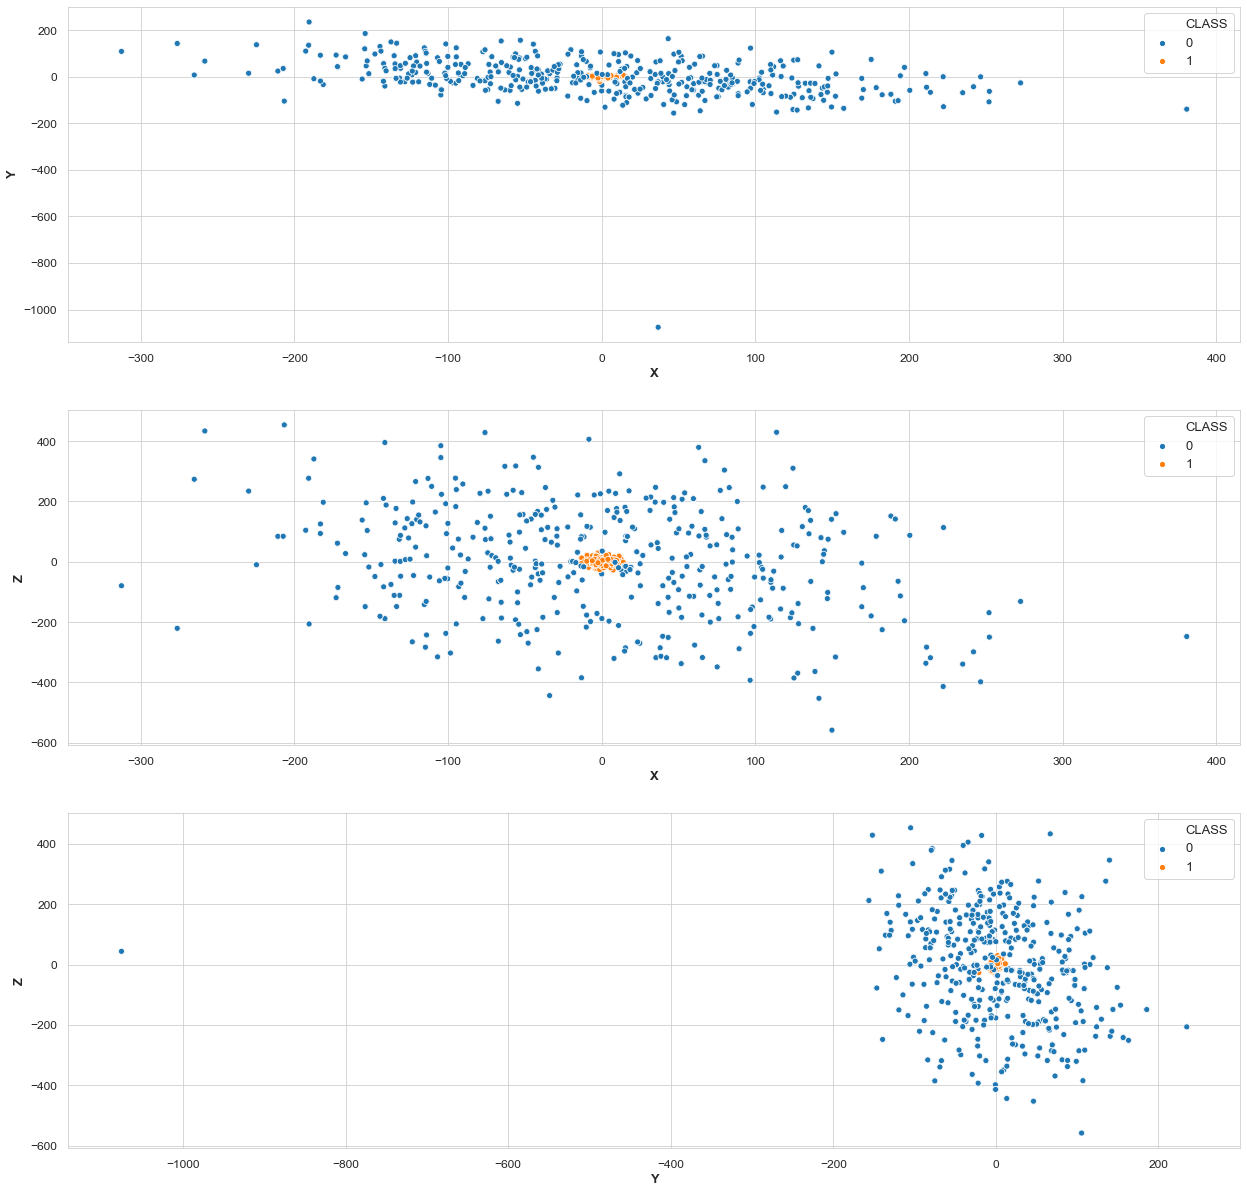

In [52]:
plt.figure(figsize = (21, 21))

plt.subplot(311)
sns.scatterplot(x = 'X', y = 'Y', data = data, hue = 'CLASS')

plt.subplot(312)
sns.scatterplot(x = 'X', y = 'Z', data = data, hue = 'CLASS')

plt.subplot(313)
sns.scatterplot(x = 'Y', y = 'Z', data = data, hue = 'CLASS')

Drawing a 2D Plot gives a very interesting result. If $x, y, z \approx 0$ then it is Class-1, else 0. Let's draw a **Heat-Map** for more information.

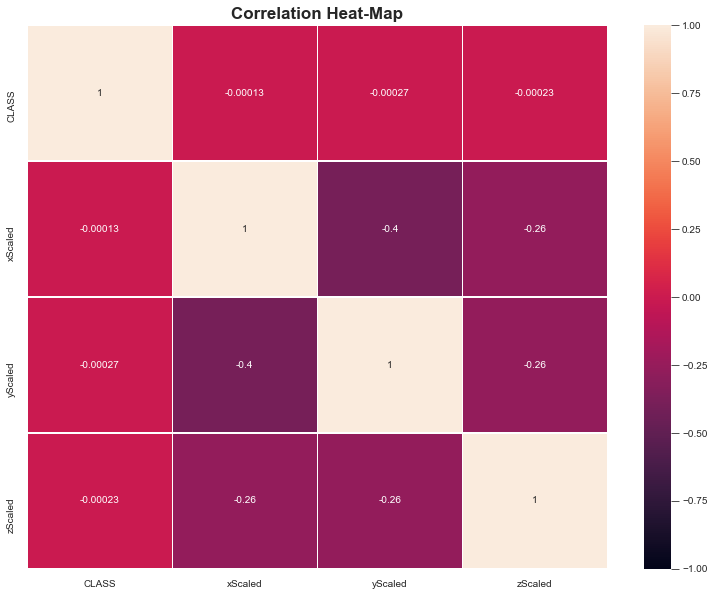

In [8]:
plt.figure(figsize = (13, 10))
sns.heatmap(data[['CLASS', 'xScaled', 'yScaled', 'zScaled']].corr(), vmin = -1, vmax = 1, annot = True, linewidths = 0.25)

plt.title('Correlation Heat-Map')
plt.show()

## Model Fitting, and Evaluation

In [44]:
FinalData = data[['CLASS', 'xScaled', 'yScaled', 'zScaled']] # Transformed Data

xVals = FinalData[['xScaled', 'yScaled', 'zScaled']].values
yVals = FinalData.CLASS.values

X_train, X_test, y_train, y_test = train_test_split(xVals, yVals, test_size = 0.3)

In [45]:
logReg = LogisticRegression(
        tol = 1e-6, l1_ratio = 1.0,
        penalty = 'elasticnet', solver = 'saga' # ElasticNet is only Supported by SAGA Solver
    )

In [46]:
logReg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=1.0, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=1e-06, verbose=0,
                   warm_start=False)

In [47]:
%%time
logReg.fit(X_train, y_train)

Wall time: 20.3 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=1.0, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=1e-06, verbose=0,
                   warm_start=False)

In [48]:
%%time
yPredicted = logReg.predict(X_test)

Wall time: 0 ns


In [49]:
metrics.confusion_matrix(y_test, yPredicted)

array([[486,   7],
       [420,   0]], dtype=int64)

In [50]:
print(f"Recall    : {metrics.recall_score(y_test, yPredicted)}")
print(f"Accuracy  : {round(metrics.accuracy_score(y_test, yPredicted), 3)}")
print(f"Precision : {metrics.precision_score(y_test, yPredicted)}")

Recall    : 0.0
Accuracy  : 0.532
Precision : 0.0


Now, lets try to predict the CLASS based only on X-Value.

In [63]:
def predictor(_xVal : int or float) -> bool:
    if (_xVal > -10) and (_xVal < 10):
        return True
    
    return False

In [72]:
%%time
yPredicted = [1 if predictor(xVal) else 0 for xVal in data.X]

Wall time: 1 ms


In [74]:
metrics.confusion_matrix(data.CLASS, yPredicted)

array([[1542,   84],
       [  48, 1368]], dtype=int64)

In [76]:
print(f"Recall    : {round(metrics.recall_score(data.CLASS, yPredicted), 3)}")
print(f"Accuracy  : {round(metrics.accuracy_score(data.CLASS, yPredicted), 3)}")
print(f"Precision : {round(metrics.precision_score(data.CLASS, yPredicted), 3)}")

Recall    : 0.966
Accuracy  : 0.957
Precision : 0.942


Thus, we can also conclude that incosistent data like this, can be evaluated with some basic analysis, without the need of any Machine Learning Model. For sake of Learning, now, lets fit the Logistic Regression Model with **PySpark**, but first we will also create a _VectorAssembler_ and Create a Pipiline to fit the Model and get the result.

## PySpark Implementation

In [3]:
!pip install pyspark

     |████████████████████████████████| 217.8MB 55.2MB/s eta 0:00:01 |█▋                              | 11.2MB 9.9MB/s eta 0:00:21     |████████████████████▎           | 137.7MB 50.5MB/s eta 0:00:02
     |████████████████████████████████| 204kB 49.7MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [16]:
try:
    from pyspark.sql import SparkSession
    from pyspark import SparkContext, SparkConf
except ImportError as e:
    raise ImportError('PySpark is not Configured')
    
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    
# Creating a Spark-Context
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
# Spark Builder
spark = SparkSession.builder.getOrCreate()

In [10]:
SparkData = spark.read.load('a2.parquet')
SparkData.createOrReplaceTempView("SparkData")
SparkData = spark.sql("""SELECT CLASS AS label, X, Y, Z FROM SparkData""")

In [11]:
SparkData.show()

+-----+-------------------+-------------------+-------------------+
|label|                  X|                  Y|                  Z|
+-----+-------------------+-------------------+-------------------+
|    0| 380.66434005495194| -139.3470983812975|-247.93697521077704|
|    0| 104.74324299209692| -32.27421440203938|-25.105013725863852|
|    0| 118.11469236129976| 45.916682927433534| -87.97203782706572|
|    0| 246.55394030642543|-0.6122810693132044|-398.18662513951506|
|    0|-190.32584900181487|  234.7849657520335|-206.34483804019288|
|    0| 178.62396382387422| -47.07529438881511|  84.38310769821979|
|    0|  85.03128805189493|-4.3024316644854546|-1.1841857567516714|
|    0| 26.786262674736566| -46.33193951911338| 20.880756008396055|
|    0|-16.203752396859194| 51.080957032176954| -96.80526656416971|
|    0|   47.2048142440404|  -78.2950899652916| 181.99604091494786|
|    0| 15.608872398939273| -79.90322809181754|  69.62150711098005|
|    0|-4.8281721129789315| -67.38050508399905| 

In [12]:
assembler    = VectorAssembler(inputCols = 'X Y Z'.split(), outputCol = "features")
logRegressor = LogisticRegression(maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)

In [13]:
LogRegModel = Pipeline(stages = [
    assembler,   # Assemble Data as Vector Objects
    logRegressor # Linear Regression Model
])

In [14]:
%%time
model      = LogRegModel.fit(SparkData)
prediction = model.transform(SparkData)

CPU times: user 20 ms, sys: 12 ms, total: 32 ms
Wall time: 3.07 s


In [15]:
prediction.show()

+-----+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------+
|label|                  X|                  Y|                  Z|            features|       rawPrediction|         probability|prediction|
+-----+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------+
|    0| 380.66434005495194| -139.3470983812975|-247.93697521077704|[380.664340054951...|[0.13828701585409...|[0.53451676528599...|       0.0|
|    0| 104.74324299209692| -32.27421440203938|-25.105013725863852|[104.743242992096...|[0.13828701585409...|[0.53451676528599...|       0.0|
|    0| 118.11469236129976| 45.916682927433534| -87.97203782706572|[118.114692361299...|[0.13828701585409...|[0.53451676528599...|       0.0|
|    0| 246.55394030642543|-0.6122810693132044|-398.18662513951506|[246.553940306425...|[0.13828701585409...|[0.53451676528599...|       0.0|
|    0

In [17]:
%%time
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.98 ms


In [18]:
print(f'Accuracy : {round(binEval.evaluate(prediction), 3)}')

Accuracy : 0.535


Thus, we have implemented **Logistic Regression** using (1) *SciKit-Learn* and (2) *SparkML*. Where, we have acheived $\approx 53.5\text{%}$ Accuracy. However, as explained, on this particular dataset, a mere accuracy of $\approx 95.5\text{%}$ is easily acheivable without using any ML Models.